#  Custom YOLOv3 Object Detection Model Implementation and Training

The rapid advancement of computer vision and deep learning has profoundly impacted the field of autonomous systems and intelligent transportation. A critical capability underpinning these technologies is robust and real-time object detection—the task of identifying and localizing objects within digital images. Among its numerous applications, vehicle detection stands out as a cornerstone for autonomous driving, traffic monitoring, surveillance, and advanced driver-assistance systems (ADAS). The ability to accurately and swiftly detect vehicles, including cars, trucks, buses, and motorcycles, is essential for tasks such as collision avoidance, traffic flow analysis, and parking management.

Traditional object detection methods, which often relied on hand-crafted features and shallow classifiers, have been largely superseded by deep convolutional neural networks (CNNs). These models can automatically learn hierarchical feature representations from data, leading to significant improvements in accuracy and robustness across varied and challenging environmental conditions. 

**The You Only Look Once (YOLO) family of algorithms, renowned for their exceptional speed-accuracy trade-off, represent a paradigm shift in this domain by framing detection as a single, unified regression problem.**

While generic object detectors perform well on broad datasets, their performance can be suboptimal for specific domains like vehicle detection. Vehicles can appear in a multitude of sizes, orientations, and occlusions, often under varying lighting and weather conditions. Furthermore, real-world applications demand not only high precision and recall but also operational efficiency, frequently requiring detection at high frame rates on potentially constrained hardware.

This project addresses the challenge of developing a specialized, high-performance vehicle detection system. The core problem involves the implementation, training, and optimization of a state-of-the-art object detection model—specifically, YOLOv3—tailored to the unique characteristics of vehicular objects. The task encompasses the entire machine learning pipeline: from dataset acquisition and preprocessing, through model design and training, to final performance evaluation and analysis.

The primary objectives of this fist part of the project are:

**Implementation**: To implement the YOLOv3 architecture from first principles, providing a detailed understanding of its core components, including the backbone feature extractor (Darknet-53), the feature pyramid network (FPN) for multi-scale prediction, and the anchor box mechanism.

***Training and Specialization***: To train the implemented YOLOv3 model on a large-scale dataset comprised of vehicular imagery. The goal is to specialize the network for the vehicle detection task, optimizing its weights to accurately predict bounding boxes and class probabilities for different vehicle types.

**Evaluation and Analysis**: To rigorously evaluate the trained model's performance using standard metrics such as mean Average Precision (mAP), precision-recall curves, and frames per second (FPS). The analysis will focus on its accuracy, speed, and failure modes in complex scenarios.

### Import the necessary packages

In [5]:
%pip install pandas numpy matplotlib seaborn opencv-python scikit-learn scikit-image imutils tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install albumentations

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

Note: you may need to restart the kernel to use updated packages.


## Helper Functions

### Intersection over Union

The Intersection over Union (IoU) is essential in the implementation of YOLOv3 because it **quantitatively measures the overlap between predicted and ground truth bounding boxes**, guiding both the training process and the evaluation of detection accuracy.

YOLOv3 uses IoU as a metric within its loss function to optimize localization (bounding box regression).

The model penalizes predictions based on how closely the predicted boxes align with actual object locations, using IoU to calculate this error.

The function receives two bounding boxes in the [x, y, width, height] format as input, as well as a boolean flag indicating whether box1 is a predicted box and box2 is a ground truth box.

The function then returns the IoU score.

In [7]:
def iou(box1, box2, is_pred=True):
    if is_pred:
        # Calculates the coordinates of the top-left (x1, y1)
        #  and bottom-right (x2, y2) corners for both boxes.

        # Box coordinates of prediction
        b1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
        b1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
        b1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
        b1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2

        # Box coordinates of ground truth
        b2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
        b2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
        b2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
        b2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2


        # Get the coordinates of the intersection rectangle by taking the 
        # maximum of the top-left coordinates and the minimum of the bottom-right coordinates.
        x1 = torch.max(b1_x1, b2_x1)
        y1 = torch.max(b1_y1, b2_y1)
        x2 = torch.min(b1_x2, b2_x2)
        y2 = torch.min(b1_y2, b2_y2)
        # Make sure the intersection is at least 0
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
        # clamp(0) is used to ensure that the intersection area
        # is not negative in cases where the boxes do not overlap.

        # Calculate the union area by adding the areas of the two boxes and 
        # subtracting the intersection area to avoid double-counting the overlapping region.
        box1_area = abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1))
        box2_area = abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1))
        union = box1_area + box2_area - intersection

        # Calculate the IoU score by dividing the intersection area by the 
        # union area. 
        # A small epsilon is added to the union to prevent division by zero.
        epsilon = 1e-6
        iou_score = intersection / (union + epsilon)

        # Return IoU score
        return iou_score

    else:
        # The case where is_pred is false is used to handle the case 
        # where box1 and box2 are in the format [width, height]. 

        # Calculate intersection area
        intersection_area = torch.min(box1[..., 0], box2[..., 0]) * \
                            torch.min(box1[..., 1], box2[..., 1])

        # Calculate union area
        box1_area = box1[..., 0] * box1[..., 1]
        box2_area = box2[..., 0] * box2[..., 1]
        union_area = box1_area + box2_area - intersection_area

        # Calculate IoU score
        iou_score = intersection_area / union_area

        # Return IoU score
        return iou_score

### Non-Maximum Suppression

At inference, IoU is used to eliminate duplicate detections through Non-Maximum Suppression (NMS).

**Only boxes with the highest confidence and a low IoU with others are kept**, ensuring each object is detected once without redundant bounding boxes.

Non-Maximum Suppression (NMS) is a crucial post-processing technique in object detection that helps eliminate redundant and overlapping bounding boxes, ensuring each detected object is represented by a single, most confident box.



The function takes a list of bounding boxes as input, where each box is represented as [class_label, confidence, x, y, width, height], along with the intersection over union and confidence threshold. 

It returns a list of filtered and suppressed bounding boxes after applying non-maximum suppression.

In [8]:
def nms(bboxes, iou_threshold, threshold):
    # Filter out bounding boxes with confidence below the threshold
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sort by confidence in descending order based on their confidence scores
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    bboxes_nms = []

    while bboxes:
        # Take the box with highest confidence
        chosen_box = bboxes.pop(0)
        bboxes_nms.append(chosen_box)

        # Remove boxes with high IoU with the chosen box
        bboxes = [
            box for box in bboxes
            if box[0] != chosen_box[0] or  # Different class
            iou(torch.tensor(chosen_box[2:]), torch.tensor(box[2:])) < iou_threshold
        ]

    return bboxes_nms

### Convert cells to bounding boxes

Converting cells to bounding boxes is necessary in object detection models like YOLO because **the model divides the input image into a grid of cells, where each cell is responsible for predicting objects whose centers fall inside it**. Each cell predicts bounding boxes that represent the possible locations and sizes of objects within that cell.

The function takes the following as input:
- Prediction: The raw output tensor from the YOLO model for a predicted scale. These raw predictions are not direct coordinates, but rather offsets and confidences that must be transformed using the anchor boxes and grid cell structure.
- Anchors: Anchor boxes associated with each scale.
- s: the grid size for the scale (13, 26 or 52).
- is_prediction: a boolean value indicating whether the input is a model prediction (True) or a ground truth label.

It returns the converted bounding boxes.

In [14]:
def convert_cells_to_bboxes(predictions, anchors, s, is_predictions=True):
    # Extract basic information from the input
    batch_size = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5] # raw boxes coordinate predictions

    if is_predictions: # If we consider the model's raw input
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2) # reshape anchors to match the dimensions of the predictions
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2]) # Apply a sigmoid function
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors # scale the predicted width and height based on the anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        # Find the class with the highest probability among the class predictions
        # and gets its index
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else: # we are considering the ground truth labels
        # Take score and class label
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    # Create cell indices
    cell_indices = (
        torch.arange(s)
        .repeat(predictions.shape[0], 3, s, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )

    # Calculate coordinates
    # converts the cell-relative predictions into image-relative coordinates (normalized between 0 and 1)

    x = 1 / s * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / s * (box_predictions[..., 1:2] +
                 cell_indices.permute(0, 1, 3, 2, 4))
    width_height = 1 / s * box_predictions[..., 2:4]

    # Concatenate the best_class, scores, x, y, and width_height tensors along the last dimension to form the 
    # complete bounding box information for each anchor box in each cell and reshapes this into a tensor where 
    # each row represents a potential bounding box and has the format [class_label, confidence, x, y, width, height].
    converted_bboxes = torch.cat(
        (best_class, scores, x, y, width_height), dim=-1
    ).reshape(batch_size, num_anchors * s * s, 6)

    return converted_bboxes.tolist()


### Plot images with bounding boxes and class labels

Plotting images with bounding boxes and class labels is essential because it provides a visual representation of what the object detection model has predicted, making the results interpretable and actionable for humans.

The function takes the original image and a list of bounding boxes as input.

In [13]:
def plot_image(image, boxes):
    # Get the color map from matplotlib
    colour_map = plt.get_cmap("tab20b")
    # Get different colors from the color map for different classes
    colors = [colour_map(i) for i in np.linspace(0, 1, len(class_labels))]

    # Read the image with OpenCV
    img = np.array(image)
    # Gett the height and width of the image
    h, w, _ = img.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Add image to plot
    ax.imshow(img)

    # Plot the bounding boxes and labels over the image
    for box in boxes:
        # Get the class from the box
        class_pred = box[0]
        # Get the center x and y coordinates
        box = box[2:]

        # Get the upper left corner coordinates: converts from center-coordinates to corner-coordinates
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2

        # Create a Rectangle patch with the bounding box
        rect = patches.Rectangle(
            (upper_left_x * w, upper_left_y * h),
            box[2] * w,
            box[3] * h,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add class name to the patch
        plt.text(
            upper_left_x * w,
            upper_left_y * h,
            s=class_labels[int(class_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    # Display the plot
    plt.show()

### Save Checkpoint

This function is a critical component of the model training pipeline. It is designed to address several key challenges associated with training large-scale deep learning models such as YOLOv3, and it is essential for saving progress during training.

It takes the model, the optimiser and the name of the file to save the checkpoint to as input.




In [12]:
def save_checkpoint(model, optimizer, filename):
    print("==> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

    # Define the path to the folder
    if filename == "checkpoint.pth.tar":
        drive_path = "/content/drive/MyDrive/Vehicle_Detection/checkpoint_custom"
    else:
        drive_path = "/content/drive/MyDrive/Vehicle_Detection/checkpoint_pretrained"
    
    # Combine the drive path and the filename
    full_path = os.path.join(drive_path, filename)
    torch.save(checkpoint, full_path)

### Load checkpoint

This function is the essential counterpart to the 'save_checkpoint' function, completing the cycle of model state persistence. It is designed to leverage saved checkpoints effectively, enabling key workflows that are fundamental to creating a robust and flexible machine learning pipeline.

The function takes the name of the file to load, the model, the optimiser and the learning rate as input.

In [10]:
# Function to load checkpoint
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("==> Loading checkpoint")
    # Define the path to the folder
    if filename == "checkpoint.pth.tar":
        drive_path = "/content/drive/MyDrive/Vehicle_Detection/checkpoint_custom"
    else:
        drive_path = "/content/drive/MyDrive/Vehicle_Detection/checkpoint_pretrained"
    # Combine the drive path and the filename
    full_path = os.path.join(drive_path, checkpoint_file)
    checkpoint = torch.load(full_path, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    # Check if optimizer state exists in checkpoint before loading
    if "optimizer" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer"])
    else:
        print("Optimizer state not found in checkpoint. Skipping optimizer loading.")


    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

### Define constants

In [21]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/xpu

Looking in indexes: https://download.pytorch.org/whl/xpu
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   -------------------------- ------------- 1.0/1.6 MB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 2.9 MB/s  0:00:00
   ---------------------------------------- 0.0/1.2 GB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 GB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 GB 2.1 MB/s eta 0:09:10
   ---------------------------------------- 0.0/1.2 GB 2.7 MB/s eta 0:07:14
   ---------------------------------------- 0.0/1.2 GB 3.1 MB/s eta 0:06:17
   ---------------------------------------- 0.0/1.2 GB 3.1 MB/s eta 0:06:0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-directml 0.2.5.dev240914 requires torch==2.4.1, but you have torch 2.8.0+xpu which is incompatible.
torch-directml 0.2.5.dev240914 requires torchvision==0.19.1, but you have torchvision 0.23.0+xpu which is incompatible.


In [33]:
# Device
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "xpu" if torch.xpu.is_available() else "cpu"


# Load and save model variable
load_model = False
save_model = True
use_pretrained = False

# model checkpoint file name
if use_pretrained:
    checkpoint_file = "best_checkpoint.pth.tar"
else :
    checkpoint_file = "checkpoint.pth.tar"

# Anchor boxes for each feature map scaled between 0 and 1
# 3 feature maps at 3 different scales based on YOLOv3 paper
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

# Batch size for training
batch_size = 16

# Learning rate for training
leanring_rate = 1e-5

# Number of epochs for training
epochs = 200

# Image size
image_size = 416

# Grid cell sizes
s = [image_size // 32, image_size // 16, image_size // 8]

# Class labels
class_labels = ["car", "threewheel", "bus", "truck", "motorbike", "van"]


In [25]:
print(device)

cpu


## Dataset


Now, we will define the dataset class to load the dataset from the folders. In this class while loading the data with its label we have to make sure of the following parts:

**Bounding box label data should be in the [x, y, width, height, class_label]** format where (x, y) represents the center coordinate of the object within the image, width is the width of the object's bounding box, height is the height of the object's bounding box, and class_label indicates the class to which the object belongs. We will follow this format because while applying transforms to the input image we need the bounding box data to be in this format to match the input transforms.

While reading the input image we have to convert it into 3-channel (RGB format) input because some of the input is in grayscale.
While loading the data, we will have target data for each box at different scales and we have to assign which anchor is responsible and which cell is responsible for the identification of that object (Generating a conditional probability map).

In [26]:
from typing import List

# Create a dataset class to load the images and labels from the folder
class Dataset(torch.utils.data.Dataset):

    # This is the constructor of the class. It initializes the dataset with various parameters
    def __init__(
        self, image_dir: str, label_dir: str, anchors: List[List[List[float]]],
        image_size=416, grid_sizes=[13, 26, 52],
        num_classes=6, transform=None
    ):

        # Image and label directories
        self.image_dir = image_dir
        self.label_dir = label_dir

        # Get all image files from the image directory
        self.image_files = sorted([
            file for file in os.listdir(image_dir)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ])


        # Image size
        self.image_size = image_size

        # Transformations
        self.transform = transform
        # Grid sizes for each scale
        self.grid_sizes = grid_sizes
        # Anchor boxes
        self.anchors = torch.tensor(
            anchors[0] + anchors[1] + anchors[2])
        # Number of anchor boxes
        self.num_anchors = self.anchors.shape[0]
        # Number of anchor boxes per scale
        self.num_anchors_per_scale = self.num_anchors // 3
        # Number of classes
        self.num_classes = num_classes
        # Ignore IoU threshold
        self.ignore_iou_thresh = 0.5

    # Returns the total number of samples in the dataset, which is the number of image files.
    def __len__(self):
        return len(self.image_files)

    # Loads and proces a single sample (image and its labels) given an index idx
    def __getitem__(self, idx):
        # Get image file
        img_file = self.image_files[idx]
        # Create corresponding label file name
        label_file = os.path.splitext(img_file)[0] + '.txt'

        # Load image
        img_path = os.path.join(self.image_dir, img_file)
        image = np.array(Image.open(img_path).convert("RGB"))

        # Load bounding boxes from label file
        label_path = os.path.join(self.label_dir, label_file)

        if os.path.exists(label_path):
            # Load bounding boxes in format [class_label, x, y, width, height]
            bboxes_raw = np.loadtxt(label_path, delimiter=' ', ndmin=2)

            # Separate bounding boxes and class labels for Albumentations
            bboxes = []
            class_labels = []

            for bbox in bboxes_raw:
                # Extract class label
                class_labels.append(int(bbox[0]))
                # Extract bbox coordinates in YOLO format [x, y, width, height]
                bboxes.append([bbox[1], bbox[2], bbox[3], bbox[4]])
        else:
            bboxes = []
            class_labels = []

        # Apply augmentations if provided
        if self.transform:
            augs = self.transform(image=image, bboxes=bboxes, class_labels=class_labels)
            image = augs["image"]
            bboxes = augs["bboxes"]
            class_labels = augs["class_labels"]

        # Recombine bboxes with class labels after transformation
        # Convert back to [x, y, width, height, class_label] format for internal processing
        combined_bboxes = []
        for bbox, class_label in zip(bboxes, class_labels):
            combined_bboxes.append([bbox[0], bbox[1], bbox[2], bbox[3], class_label])

        # prepares the targets tensor for each of the YOLO output scales. 
        # These tensors are initially filled with zeros and will be populated with the ground truth information in a format suitable for calculating the YOLO loss.
        targets = [torch.zeros((self.num_anchors_per_scale, s, s, 6))
                for s in self.grid_sizes]


        for box in combined_bboxes:
            # Calculate IoU between the box and all anchors
            # to determine which anchor is most appropriate for this box.
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors, is_pred=False)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3

            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                s = self.grid_sizes[scale_idx]
                i, j = int(s * y), int(s * x)
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = s * x - j, s * y - i
                    width_cell, height_cell = width * s, height * s
                    box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1

        return image, tuple(targets)

### Data Transformation


Now, for training and testing, we will need to define transforms on which the input data will be processed before feeding it to the network. For this, we will make use of the argumentation library in Pytorch which provides efficient transforms for both image and bounding boxes.

In [27]:
# Transform for training
# A.Compose allows to chain multiple augmentation techniques together.
train_transform = A.Compose(
    [
        # Rescale an image so that maximum side is equal to image_size
        A.LongestMaxSize(max_size=image_size),
        # Pad remaining areas with zeros
        A.PadIfNeeded(
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT
        ),
        # Random color jittering: randomly changes the brightness, contrast, saturation, and hue of the image.
        A.ColorJitter(
            brightness=0.5, contrast=0.5,
            saturation=0.5, hue=0.5, p=0.5
        ),
        # Flip the image horizontally
        A.HorizontalFlip(p=0.5),
        # Normalize the image
        A.Normalize(
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ),
        # Convert the image to PyTorch tensor
        ToTensorV2()
    ],
    # Augmentation for bounding boxes:
    # specifies how the bounding boxes should be handled during the transformations
    bbox_params=A.BboxParams(
                    format="yolo",
                    min_visibility=0.4,
                    label_fields=["class_labels"]  # Added label field
                )
)

# Transform for testing
test_transform = A.Compose(
    [
        # Rescale an image so that maximum side is equal to image_size
        A.LongestMaxSize(max_size=image_size),
        # Pad remaining areas with zeros
        A.PadIfNeeded(
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT
        ),
        # Normalize the image
        A.Normalize(
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ),
        # Convert the image to PyTorch tensor
        ToTensorV2()
    ],
    # Augmentation for bounding boxes
    bbox_params=A.BboxParams(
                    format="yolo",
                    min_visibility=0.4,
                    label_fields=["class_labels"]  # Added label field
                )
)

### Load the dataset

This dataset contains labelled images of vehicles gathered from Kaggle, the Stanford Car Dataset and web scraping.

Dataset size: 3,000 images.
 
Each class: 500 images.

Format: YOLO (txt).

Training/validation split: 70% (2,100 images): 30% (900 images).

The classes are: Car, Three-wheeler, Bus, Truck, Motorbike, Van



C:\Users\anna9\AppData\Local\Temp\ipykernel_33312\2929463527.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = np.array(image)


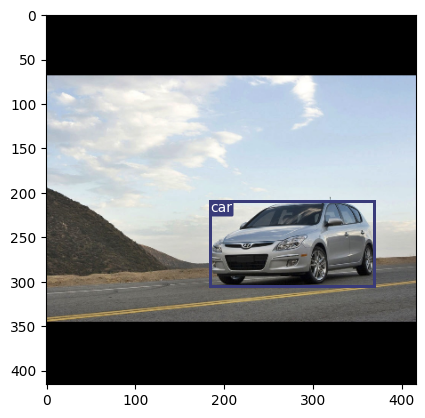

In [28]:
# Creating a dataset object
dataset = Dataset(
    image_dir="vehicle_dataset/train/images",
    label_dir="vehicle_dataset/train/labels",
    grid_sizes=[13, 26, 52],
    anchors=ANCHORS,
    transform=test_transform
)

# Creating a dataloader object
loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=True,
)

# Defining the grid size and the scaled anchors
GRID_SIZE = [13, 26, 52]
scaled_anchors = torch.tensor(ANCHORS) / (
    1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
)

# Getting a batch from the dataloader
x, y = next(iter(loader))

# Getting the boxes coordinates from the labels
# and converting them into bounding boxes without scaling
boxes = []
for i in range(y[0].shape[1]):
    anchor = scaled_anchors[i]
    boxes += convert_cells_to_bboxes(
               y[i], is_predictions=False, s=y[i].shape[2], anchors=anchor
             )[0]

# Applying non-maximum suppression
boxes = nms(boxes, iou_threshold=1, threshold=0.7)

# Plotting the image with the bounding boxes
plot_image(x[0].permute(1,2,0).to("cpu"), boxes)

## Build the model

The authors of YOLO (v3) introduced Darknet-54, a new version of Darknet containing 54 layers, as the backbone of this architecture.

Bounding boxes are predicted at three different points on three different scales or grid sizes within this network. The idea behind this approach is that small objects will be easily detected on smaller grids, while large objects will be detected on larger ones. In YOLO (v3), the authors used grid sizes of [13, 26, 52] with an image size of 416×416.

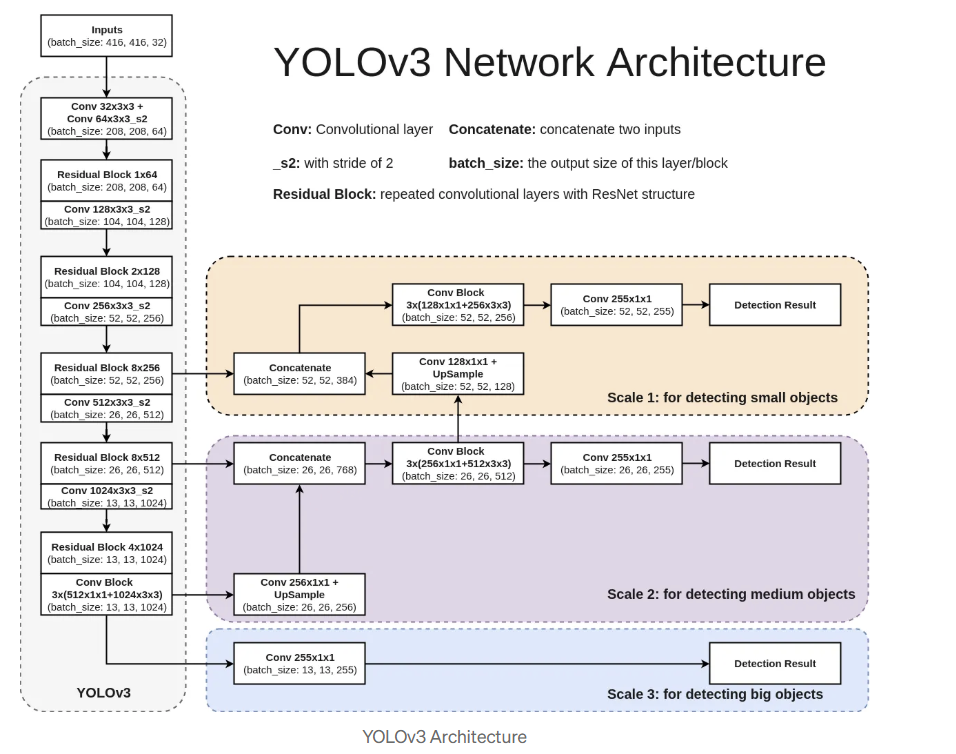

This network contains three main components: a CNN block, a residual block and a scale prediction block. First, we will code the components of the network, and then use them to define our YOLO (v3) network. 

### CNN Block

In [29]:
# Defining CNN Block
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batch_norm=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not use_batch_norm, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.1)
        self.use_batch_norm = use_batch_norm

    def forward(self, x):
        # Applying convolution
        x = self.conv(x)
        # Applying BatchNorm and activation if needed
        if self.use_batch_norm:
            x = self.bn(x)
            return self.activation(x)
        else:
            return x

### Residual block

Now we will define residual block. We will be looping the layers in the residual block based on number defined in the architecture.

In [30]:
# Defining residual block
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()

        # Defining all the layers in a list and adding them based on number of
        # repeats mentioned in the design
        res_layers = []
        for _ in range(num_repeats):
            res_layers += [
                nn.Sequential(
                    nn.Conv2d(channels, channels // 2, kernel_size=1),
                    nn.BatchNorm2d(channels // 2),
                    nn.LeakyReLU(0.1),
                    nn.Conv2d(channels // 2, channels, kernel_size=3, padding=1),
                    nn.BatchNorm2d(channels),
                    nn.LeakyReLU(0.1)
                )
            ]
        self.layers = nn.ModuleList(res_layers)
        self.use_residual = use_residual
        self.num_repeats = num_repeats

    # Defining forward pass
    def forward(self, x):
        for layer in self.layers:
            residual = x
            x = layer(x)
            if self.use_residual:
                x = x + residual
        return x

### Scale Prediction

In [31]:
# Defining scale prediction class
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Defining the layers in the network
        self.pred = nn.Sequential(
            nn.Conv2d(in_channels, 2*in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*in_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(2*in_channels, (num_classes + 5) * 3, kernel_size=1),
        )
        self.num_classes = num_classes

    # Defining the forward pass and reshaping the output to the desired output
    # format: (batch_size, 3, grid_size, grid_size, num_classes + 5)
    def forward(self, x):
        output = self.pred(x)
        output = output.view(x.size(0), 3, self.num_classes + 5, x.size(2), x.size(3))
        output = output.permute(0, 1, 3, 4, 2)
        return output

### YOLOv3 model

We will now use these components to code the YOLOv3 network.

In [32]:
# Class for defining YOLOv3 model
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=6):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels

        # Layers list for YOLOv3
        self.layers = nn.ModuleList([
            CNNBlock(in_channels, 32, kernel_size=3, stride=1, padding=1),
            CNNBlock(32, 64, kernel_size=3, stride=2, padding=1),
            ResidualBlock(64, num_repeats=1),
            CNNBlock(64, 128, kernel_size=3, stride=2, padding=1),
            ResidualBlock(128, num_repeats=2),
            CNNBlock(128, 256, kernel_size=3, stride=2, padding=1),
            ResidualBlock(256, num_repeats=8),
            CNNBlock(256, 512, kernel_size=3, stride=2, padding=1),
            ResidualBlock(512, num_repeats=8),
            CNNBlock(512, 1024, kernel_size=3, stride=2, padding=1),
            ResidualBlock(1024, num_repeats=4),
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0),
            CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1),
            ResidualBlock(1024, use_residual=False, num_repeats=1),
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0),
            ScalePrediction(512, num_classes=num_classes),
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
            nn.Upsample(scale_factor=2),
            CNNBlock(768, 256, kernel_size=1, stride=1, padding=0),
            CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
            ResidualBlock(512, use_residual=False, num_repeats=1),
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
            ScalePrediction(256, num_classes=num_classes),
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0),
            nn.Upsample(scale_factor=2),
            CNNBlock(384, 128, kernel_size=1, stride=1, padding=0),
            CNNBlock(128, 256, kernel_size=3, stride=1, padding=1),
            ResidualBlock(256, use_residual=False, num_repeats=1),
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0),
            ScalePrediction(128, num_classes=num_classes)
        ])

    # Forward pass for YOLOv3 with route connections and scale predictions
    def forward(self, x):
        outputs = []
        route_connections = []

        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue
            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
        return outputs

## Training

For training the model, we need to define a loss function on which our model can optimize. The paper discusses that the YOLO (v3) architecture was optimized on a combination of four losses: no object loss, object loss, box coordinate loss, and class loss. The loss function is defined as:

$L(x, y, w, h, c, p, pc, tc, tx, ty, tw, th)= \lambda_{coord} \times L_{coord} + \lambda_{obj}\times L_{obj}+ \lambda_{noobj} \times L_{noonbj}+ \lambda_{class}\times L_{class}$

where,

- $λ_{coord}$, $λ_{obj}$, $λ_{noobj}$, and $λ_{class}$ are constants that weight the different components of the loss function (they are set to 1 in the paper).
- $L_{coord}$ penalizes the errors in the bounding box coordinates.
- $L_{obj}$ penalizes the confidence predictions for object detection.
- $L_{noobj}$ penalizes the confidence predictions for background regions.
- $L_{class}$ penalizes the errors in the class predictions.

In [34]:
class YOLOLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

    def forward(self, pred, target, anchors):
        # Identifying which cells in target have objects
        # and which have no objects
        obj = target[..., 0] == 1
        no_obj = target[..., 0] == 0

        # Calculating No object loss
        no_object_loss = self.bce(
            (pred[..., 0:1][no_obj]), (target[..., 0:1][no_obj]),
        )


        # Reshaping anchors to match predictions
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        # Box prediction confidence
        box_preds = torch.cat([self.sigmoid(pred[..., 1:3]),
                               torch.exp(pred[..., 3:5]) * anchors
                            ],dim=-1)
        # Calculating intersection over union for prediction and target
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach()
        # Calculating Object loss
        object_loss = self.mse(self.sigmoid(pred[..., 0:1][obj]),
                               ious * target[..., 0:1][obj])


        # Predicted box coordinates
        pred[..., 1:3] = self.sigmoid(pred[..., 1:3])
        # Target box coordinates
        target[..., 3:5] = torch.log(1e-6 + target[..., 3:5] / anchors)
        # Calculating box coordinate loss
        box_loss = self.mse(pred[..., 1:5][obj],
                            target[..., 1:5][obj])


        # Claculating class loss
        class_loss = self.cross_entropy((pred[..., 5:][obj]),
                                   target[..., 5][obj].long())

        # Total loss
        return (
            box_loss
            + object_loss
            + no_object_loss
            + class_loss
        )

### Training loop for custom model from scratch

In [35]:
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors, best_loss):
    # Creating a progress bar
    progress_bar = tqdm(loader, leave=True)

    # Initializing a list to store the losses
    losses = []

    # Iterating over the training data
    for _, (x, y) in enumerate(progress_bar):
        x = x.to(device)
        y0, y1, y2 = (
            y[0].to(device),
            y[1].to(device),
            y[2].to(device),
        )

        with torch.cuda.amp.autocast():
            # Getting the model predictions
            outputs = model(x)
            # Calculating the loss at each scale
            loss = (
                  loss_fn(outputs[0], y0, scaled_anchors[0])
                + loss_fn(outputs[1], y1, scaled_anchors[1])
                + loss_fn(outputs[2], y2, scaled_anchors[2])
            )

        # Add the loss to the list
        losses.append(loss.item())

        # Reset gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        scaler.scale(loss).backward()

        # Optimization step
        scaler.step(optimizer)

        # Update the scaler for next iteration
        scaler.update()

        # update progress bar with loss
        mean_loss = sum(losses) / len(losses)
        progress_bar.set_postfix(loss=mean_loss)

    # Save the model only if the current mean loss is lower than the best loss
    if mean_loss < best_loss:
        if save_model:
            save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")
        return mean_loss # Return the new best loss
    else:
        return best_loss # Return the previous best loss

In [ ]:
# Creating the model from YOLOv3 class
model = YOLOv3().to(device)

# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr = leanring_rate)

# Defining the loss function
loss_fn = YOLOLoss()

# Defining the scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Defining the train dataset
train_dataset = Dataset(
    image_dir="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/train/images",
    label_dir="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/train/labels",
    anchors=ANCHORS,
    transform=train_transform
)

# Defining the train data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    num_workers = 2,
    shuffle = True,
    pin_memory = True,
)

# Scaling the anchors
scaled_anchors = (
    torch.tensor(ANCHORS) *
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2)
).to(device)

# Initialize best_loss to infinity
best_loss = float('inf')

# Training the model
for e in range(1, epochs+1):
    print("Epoch:", e)
    # Update best_loss with the returned value from training_loop
    best_loss = training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors, best_loss)



### Training loop for custom model using pretrained weights

#### Load Pre-Trained weights

We need to load pre-trained weights and apply them to the custom model.

In [57]:
# Build mapping between layer structures:
    # parses the layer names of both custom model and the pre-trained model and
    # groups them by their index and type.
def create_layer_mapping(model_dict, pretrained_dict, matched_dict):

    mapping = {}
    


    # Sort keys to process in order
    model_keys = sorted([k for k in model_dict.keys()])
    pretrained_keys = sorted([k for k in pretrained_dict.keys()])

    # Group layers by module index
    model_modules = {}
    pretrained_modules = {}

    # Parse model layer structure:
    # breaks names line layers.0.conv.weight into layer_idx, layer_type, parameter_type
    for key in model_keys:
        if key.startswith('layers.'):
            parts = key.split('.')
            if len(parts) >= 3:
                layer_idx = int(parts[1])
                layer_type = parts[2]  # conv, bn
                param_type = parts[3] if len(parts) > 3 else 'weight'

                if layer_idx not in model_modules:
                    model_modules[layer_idx] = {}
                if layer_type not in model_modules[layer_idx]:
                    model_modules[layer_idx][layer_type] = {}

                model_modules[layer_idx][layer_type][param_type] = key

    # Parse pretrained layer structure
    for key in pretrained_keys:
        if key.startswith('module_list.'):
            parts = key.split('.')
            if len(parts) >= 3:
                module_idx = int(parts[1])
                layer_type = parts[2]  # Conv2d, BatchNorm2d
                param_type = parts[3] if len(parts) > 3 else 'weight'

                if module_idx not in pretrained_modules:
                    pretrained_modules[module_idx] = {}
                if layer_type not in pretrained_modules[module_idx]:
                    pretrained_modules[module_idx][layer_type] = {}

                pretrained_modules[module_idx][layer_type][param_type] = key

    return model_modules, pretrained_modules

In [58]:
# Use the structural maps to create a correspondence between layer indices in the custom
# model and the pre-trained model
def match_layers_systematically(model_dict, pretrained_dict, matched_dict):

    model_modules, pretrained_modules = create_layer_mapping(model_dict, pretrained_dict, matched_dict)

    matched = 0

    # Print some structure for debugging
    print("\nModel structure (first 5 modules):")
    for i in sorted(list(model_modules.keys())[:5]):
        print(f"  layers.{i}: {list(model_modules[i].keys())}")

    print("\nPretrained structure (first 5 modules):")
    for i in sorted(list(pretrained_modules.keys())[:5]):
        print(f"  module_list.{i}: {list(pretrained_modules[i].keys())}")

    # Strategy 1: Direct systematic matching
    # Try to match layers in sequence
    model_layer_indices = sorted(model_modules.keys())
    pretrained_module_indices = sorted(pretrained_modules.keys())

    # Create a mapping between model layers and pretrained modules
    layer_mapping = {}

    # Manual mapping for common layer types:
    # Finds indices of convolutional layers in both models
    conv_layers_model = []
    conv_layers_pretrained = []

    for idx in model_layer_indices:
        if 'conv' in model_modules[idx]:
            conv_layers_model.append(idx)

    for idx in pretrained_module_indices:
        if 'Conv2d' in pretrained_modules[idx]:
            conv_layers_pretrained.append(idx)

    print(f"\nFound {len(conv_layers_model)} conv layers in model")
    print(f"Found {len(conv_layers_pretrained)} conv layers in pretrained")

    # Map conv layers: matches conv layers in sequence (0 → 0, 1 → 1, etc.)
    for i, model_layer in enumerate(conv_layers_model):
        if i < len(conv_layers_pretrained):
            pretrained_layer = conv_layers_pretrained[i]
            layer_mapping[model_layer] = pretrained_layer
            print(f"Mapping layers.{model_layer} -> module_list.{pretrained_layer}")

    # Now match all parameters for mapped layers:
    # Matches convolution weights and biases if shapes match.

    for model_layer_idx, pretrained_layer_idx in layer_mapping.items():
        model_module = model_modules[model_layer_idx]
        pretrained_module = pretrained_modules.get(pretrained_layer_idx, {})

        # Match conv parameters
        if 'conv' in model_module and 'Conv2d' in pretrained_module:
            for param_type in ['weight', 'bias']:
                if param_type in model_module['conv'] and param_type in pretrained_module['Conv2d']:
                    model_key = model_module['conv'][param_type]
                    pretrained_key = pretrained_module['Conv2d'][param_type]

                    if model_dict[model_key].shape == pretrained_dict[pretrained_key].shape:
                        matched_dict[model_key] = pretrained_dict[pretrained_key]
                        matched += 1
                        print(f"  Matched {param_type}: {model_key} <- {pretrained_key}")

        # Match batch norm parameters
        if 'bn' in model_module and 'BatchNorm2d' in pretrained_module:
            for param_type in ['weight', 'bias', 'running_mean', 'running_var']:
                if param_type in model_module['bn'] and param_type in pretrained_module['BatchNorm2d']:
                    model_key = model_module['bn'][param_type]
                    pretrained_key = pretrained_module['BatchNorm2d'][param_type]

                    if model_dict[model_key].shape == pretrained_dict[pretrained_key].shape:
                        matched_dict[model_key] = pretrained_dict[pretrained_key]
                        matched += 1
                        print(f"  Matched {param_type}: {model_key} <- {pretrained_key}")

    return matched

In [59]:
def load_yolov3_weights(model, weights_path='yolov3u.pt'):

    # Load safely the checkpoint file
    try:
        checkpoint = torch.load(weights_path, map_location=device, weights_only=True)
    except TypeError:
        checkpoint = torch.load(weights_path, map_location=device)

    # Extract state dict, chechking its type and content
    if isinstance(checkpoint, dict) and 'model' in checkpoint:
        model_obj = checkpoint['model']
        if hasattr(model_obj, 'state_dict'):
            pretrained_dict = model_obj.state_dict()
        else:
            pretrained_dict = model_obj
    else:
        pretrained_dict = checkpoint

    # Extracts the actual parameter tensors from a model object
    model_dict = model.state_dict()

    # Prints out the number of parameters in both models
    print(f"Model has {len(model_dict)} parameters")
    print(f"Pretrained has {len(pretrained_dict)} parameters")

    # Create systematic layer mapping
    matched_dict = {} # store matched parameters
    matched_count = 0 # how many layers were successfully matched


    # Try systematic matching first
    matched_count += match_layers_systematically(model_dict, pretrained_dict, matched_dict)

    # Strategy 2: Enhanced shape-based matching for remaining layers
    unmatched_model_keys = [k for k in model_dict.keys() if k not in matched_dict]
    used_pretrained_keys = set(matched_dict.values())

    for model_key in unmatched_model_keys:
        model_param = model_dict[model_key]

        for pretrained_key, pretrained_param in pretrained_dict.items():
            if pretrained_key in used_pretrained_keys:
                continue

            # If shapes match and layer types match (conv ↔ Conv2d, bn ↔ BatchNorm2d), copy weights.

            if model_param.shape == pretrained_param.shape:
                # Enhanced matching logic
                model_parts = model_key.split('.')
                pretrained_parts = pretrained_key.split('.')

                # Match parameter types (weight, bias, running_mean, running_var)
                model_param_type = model_parts[-1]
                pretrained_param_type = pretrained_parts[-1]

                if model_param_type == pretrained_param_type:
                    # Match layer types
                    model_layer_type = None
                    pretrained_layer_type = None

                    if 'conv' in model_key:
                        model_layer_type = 'conv'
                    elif 'bn' in model_key:
                        model_layer_type = 'bn'

                    if 'Conv2d' in pretrained_key:
                        pretrained_layer_type = 'conv'
                    elif 'BatchNorm2d' in pretrained_key:
                        pretrained_layer_type = 'bn'

                    if model_layer_type == pretrained_layer_type:
                        matched_dict[model_key] = pretrained_param
                        used_pretrained_keys.add(pretrained_key)
                        matched_count += 1
                        print(f"Shape-matched {model_param_type}: {model_key} <- {pretrained_key}")
                        break

    # Fill remaining with original weights
    for model_key in model_dict.keys():
        if model_key not in matched_dict:
            matched_dict[model_key] = model_dict[model_key]

    print(f"\n==> Successfully matched {matched_count}/{len(model_dict)} layers ({matched_count/len(model_dict)*100:.1f}%)")

    if matched_count > 50:  # Reasonable threshold
        model.load_state_dict(matched_dict, strict=False)
        print("==> Pretrained weights loaded successfully!")
        return True
    else:
        print("==> Too few layers matched, using original weights")
        return False


In [60]:

# Use the enhanced function
model = YOLOv3(in_channels=3, num_classes=len(class_labels)).to(device)
success = load_yolov3_weights(model, 'yolov3.pt')


Model has 493 parameters
Pretrained has 438 parameters

Model structure (first 5 modules):
  layers.0: ['bn', 'conv']
  layers.1: ['bn', 'conv']
  layers.10: ['layers']
  layers.11: ['bn', 'conv']
  layers.12: ['bn', 'conv']

Pretrained structure (first 5 modules):
  module_list.0: ['BatchNorm2d', 'Conv2d']
  module_list.1: ['BatchNorm2d', 'Conv2d']
  module_list.10: ['BatchNorm2d', 'Conv2d']
  module_list.100: ['BatchNorm2d', 'Conv2d']
  module_list.101: ['BatchNorm2d', 'Conv2d']

Found 17 conv layers in model
Found 75 conv layers in pretrained
Mapping layers.0 -> module_list.0
Mapping layers.1 -> module_list.1
Mapping layers.3 -> module_list.2
Mapping layers.5 -> module_list.3
Mapping layers.7 -> module_list.5
Mapping layers.9 -> module_list.6
Mapping layers.11 -> module_list.7
Mapping layers.12 -> module_list.9
Mapping layers.14 -> module_list.10
Mapping layers.16 -> module_list.12
Mapping layers.18 -> module_list.13
Mapping layers.19 -> module_list.14
Mapping layers.21 -> module_li

#### Training loop

In [ ]:
# Install compatible PyTorch version
%pip install torch==2.0.1 torchvision==0.15.2

# Creating the model from YOLOv3 class
model = YOLOv3().to(device)


use_pretrained = True  # Set this to True to use pretrained weights

if use_pretrained:
    try:
        # Download YOLOv3 weights if not present
        weights_url = "https://github.com/ultralytics/yolov3/releases/download/v1.0/yolov3.pt"
        weights_path = "/content/drive/MyDrive/Vehicle_Detection/yolov3.pt"

        if not os.path.exists(weights_path):
            print("Downloading pretrained YOLOv3 weights...")
            response = requests.get(weights_url)
            with open(weights_path, 'wb') as f:
                f.write(response.content)
            print("Download completed!")

        # Load pretrained weights
        model = load_pretrained_yolov3_weights(model, weights_path)

    except Exception as e:
        print(f"Failed to load pretrained weights: {e}")
        print("Training from scratch...")

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")


# Updated training parameters for finetuning
# Lower learning rate for finetuning pretrained weights
learning_rate = 1e-4 if use_pretrained else 1e-3

# Reduced epochs since we're finetuning
epochs = 100 if use_pretrained else 200



# freeze certain layers initially
def freeze_backbone(model, freeze=True):
    for i, layer in enumerate(model.layers):
        # Freeze first few layers (backbone)
        if i < 10:
            for param in layer.parameters():
                param.requires_grad = not freeze

    print(f"Backbone layers {'frozen' if freeze else 'unfrozen'}")

# Option to freeze backbone initially
freeze_initial_layers = False
if use_pretrained and freeze_initial_layers:
    freeze_backbone(model, freeze=True)
    print("Initial layers frozen for finetuning")


# Enhanced training with pretrained weights support
optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=learning_rate,
    weight_decay=1e-4
)

# Learning rate scheduler for finetuning
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[epochs//3, 2*epochs//3],
    gamma=0.1
)


def unfreeze_schedule(epoch, model):
    """Gradually unfreeze layers during training"""
    if use_pretrained and freeze_initial_layers:
        if epoch == epochs // 4:  # Unfreeze after 25% of training
            freeze_backbone(model, freeze=False)
            print(f"Unfrozing backbone at epoch {epoch}")

            # Update optimizer to include newly unfrozen parameters
            optimizer.param_groups[0]['params'] = [p for p in model.parameters() if p.requires_grad]

# Defining the loss function
loss_fn = YOLOLoss()

# Defining the scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Defining the train dataset
train_dataset = Dataset(
    image_dir="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/train/images",
    label_dir="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/train/labels",
    anchors=ANCHORS,
    transform=train_transform
)

# Defining the train data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    num_workers = 2,
    shuffle = True,
    pin_memory = True,
)

# Scaling the anchors
scaled_anchors = (
    torch.tensor(ANCHORS) *
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2)
).to(device)


In [ ]:
def train_with_pretrained():
    # Create model
    model = YOLOv3(in_channels=3, num_classes=len(class_labels)).to(device)

    # Load pretrained weights
    load_success = False
    if use_pretrained:
        # Pass the weights path to the loading function
        print("Attempting to load pretrained weights...")
        load_success = load_yolov3_weights(model, '/content/drive/MyDrive/Vehicle_Detection/yolov3.pt')

    if not load_success:
        print("Failed to load pretrained weights. Training from scratch with random initialization.")
        # The model is already initialized randomly, so we can proceed.

    # Setup optimizer and loss
    # Only optimize parameters that require gradients
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        lr=learning_rate,
        weight_decay=1e-4
    )

    loss_fn = YOLOLoss()
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[epochs // 3, 2 * epochs // 3],
        gamma=0.1
    )

    # Initialize best loss
    best_loss = float('inf')

    # Load checkpoint if resuming
    if load_model:
        # Ensure checkpoint_file is defined and accessible
        try:
            load_checkpoint(checkpoint_file, model, optimizer, learning_rate)
        except Exception as e:
            print(f"Failed to load checkpoint: {e}. Starting training without loading checkpoint.")


    # Training loop
    model.train()
    for epoch in range(epochs):
        # Ensure unfreeze_schedule is defined if used, currently commented out
        # unfreeze_schedule(epoch, model)

        loop = tqdm(train_loader, leave=True)
        losses = []

        for batch_idx, (x, y) in enumerate(loop):
            x = x.to(device)
            y0, y1, y2 = (y[0].to(device), y[1].to(device), y[2].to(device))

            optimizer.zero_grad()
            out = model(x)
            loss = (loss_fn(out[0], y0, scaled_anchors[0]) +
                   loss_fn(out[1], y1, scaled_anchors[1]) +
                   loss_fn(out[2], y2, scaled_anchors[2]))

            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            # Update progress bar
            mean_loss = sum(losses) / len(losses)
            loop.set_postfix(loss=mean_loss, epoch=epoch)

        scheduler.step()

        # Save checkpoint if current loss is the best
        if save_model and mean_loss < best_loss:
            best_loss = mean_loss
            save_checkpoint(model, optimizer, filename=f"best_checkpoint.pth.tar")
            print(f"Saved best model with loss: {best_loss:.4f}")

In [ ]:
train_with_pretrained()

## Testing

In the following we test the trained YOLOv3 model on a sample batch from the test dataset and visualize the results.

### Test model trained from scratch

In [64]:

# Taking a sample image and testing the model

# Setting the load_model to True
load_model = True

# Defining the model, optimizer, loss function and scaler
model = YOLOv3().to(device)
optimizer = optim.Adam(model.parameters(), lr=leanring_rate)  # Fixed typo
loss_fn = YOLOLoss()
scaler = torch.amp.GradScaler('cuda')  # Updated deprecated GradScaler
checkpoint_file="chechkpoint.pth.tar"
# Loading the checkpoint
if load_model:
    load_checkpoint(checkpoint_file, model, optimizer, leanring_rate)

# Defining the test dataset and data loader
test_dataset = Dataset(
    image_dir="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/valid/images",
    label_dir="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/valid/labels",
    grid_sizes=[13, 26, 52],
    anchors=ANCHORS,
    transform=test_transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=5,
    shuffle=True,
)

# Getting a sample image from the test data loader
x, y = next(iter(test_loader))
x = x.to(device)

model.eval()
with torch.no_grad():
    # Getting the model predictions
    output = model(x)
    print("Model output shapes:", [o.shape for o in output])

    # Getting the bounding boxes from the predictions
    bboxes = [[] for _ in range(x.shape[0])]

    # Define scaled anchors for predictions
    scaled_anchors = (
        torch.tensor(ANCHORS) *
        torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(device)

    # Getting bounding boxes for each scale (predictions)
    for i in range(3):
        batch_size, A, S, _, _ = output[i].shape
        anchor = scaled_anchors[i]
        boxes_scale_i = convert_cells_to_bboxes(
            output[i], anchor, s=S, is_predictions=True
        )
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] += box

    # Processing each image in the batch
    for i in range(x.shape[0]):  # batch_size
        confidences_before_nms = [box[1] for box in bboxes[i]]
        print(f"\nImage {i}:")
        print(f"Top 5 maximum confidences BEFORE NMS: {sorted(confidences_before_nms, reverse=True)[:5]}")
        print(f"Number of predicted bounding boxes before NMS: {len(bboxes[i])}")

        # Applying non-max suppression to remove overlapping bounding boxes
        nms_boxes = nms(bboxes[i], iou_threshold=0.1, threshold=0.8)
        print(f"Number of predicted bounding boxes after NMS: {len(nms_boxes)}")

        # Get ground truth bounding boxes for the current image
        true_bboxes = []

        # Process ground truth for each scale
        for scale_idx in range(3):
            # Get the target for this scale
            target = y[scale_idx][i]  # Shape: [3, S, S, 6]
            S = target.shape[1]  # Grid size for this scale

            # Get anchors for this scale
            anchor = scaled_anchors[scale_idx]

            # Convert ground truth cells to bboxes
            gt_boxes_scale = convert_cells_to_bboxes(
                target.unsqueeze(0), anchor, s=S, is_predictions=False
            )

        # Add boxes from this scale
        if len(gt_boxes_scale) > 0:
            true_bboxes.extend(gt_boxes_scale[0])

        # Filter out boxes with confidence/objectness score of 0 (no object)
        true_bboxes = [box for box in true_bboxes if box[1] > 0]

        print(f"Number of ground truth bounding boxes: {len(true_bboxes)}")

        # Plotting the image with predicted bounding boxes
        if len(nms_boxes) > 0:
            print("Predicted bounding boxes:")
            plot_image(x[i].permute(1, 2, 0).to("cpu"), nms_boxes)
        else:
            print("No predicted bounding boxes after NMS")

        # Plotting the image with ground truth bounding boxes
        if len(true_bboxes) > 0:
            print("Ground truth bounding boxes:")
            plot_image(x[i].permute(1, 2, 0).to("cpu"), true_bboxes)
        else:
            print("No ground truth bounding boxes found")

        # Print image filename
        print(f"Image file: {test_dataset.image_files[i]}")

print("Testing completed!")

ImportError: cannot import name 'set_guard_fail_hook' from 'torch._dynamo.eval_frame' (c:\Users\anna9\miniconda3\envs\gpu_conda\lib\site-packages\torch\_dynamo\eval_frame.py)

### Test model trained with pretrained weights

In [ ]:

# Taking a sample image and testing the model

# Setting the load_model to True
load_model = True

# Defining the model, optimizer, loss function and scaler
model = YOLOv3().to(device)
optimizer = optim.Adam(model.parameters(), lr=leanring_rate)  # Fixed typo
loss_fn = YOLOLoss()
scaler = torch.amp.GradScaler('cuda')  # Updated deprecated GradScaler

checkpoint_file="/content/drive/MyDrive/Vehicle_Detection/checkpoint_pretrained/best_checkpoint.pth.tar"

# Loading the checkpoint
if load_model:
    load_checkpoint(checkpoint_file, model, optimizer, leanring_rate)

# Defining the test dataset and data loader
test_dataset = Dataset(
    image_dir="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/valid/images",
    label_dir="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/valid/labels",
    grid_sizes=[13, 26, 52],
    anchors=ANCHORS,
    transform=test_transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=7,
    shuffle=True,
)

# Getting a sample image from the test data loader
x, y = next(iter(test_loader))
x = x.to(device)

model.eval()
with torch.no_grad():
    # Getting the model predictions
    output = model(x)
    print("Model output shapes:", [o.shape for o in output])

    # Getting the bounding boxes from the predictions
    bboxes = [[] for _ in range(x.shape[0])]

    # Define scaled anchors for predictions
    scaled_anchors = (
        torch.tensor(ANCHORS) *
        torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(device)

    # Getting bounding boxes for each scale (predictions)
    for i in range(3):
        batch_size, A, S, _, _ = output[i].shape
        anchor = scaled_anchors[i]
        boxes_scale_i = convert_cells_to_bboxes(
            output[i], anchor, s=S, is_predictions=True
        )
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] += box

    # Processing each image in the batch
    for i in range(x.shape[0]):  # batch_size
        confidences_before_nms = [box[1] for box in bboxes[i]]
        print(f"\nImage {i}:")
        print(f"Top 5 maximum confidences BEFORE NMS: {sorted(confidences_before_nms, reverse=True)[:5]}")
        print(f"Number of predicted bounding boxes before NMS: {len(bboxes[i])}")

        # Applying non-max suppression to remove overlapping bounding boxes
        nms_boxes = nms(bboxes[i], iou_threshold=0.2, threshold=0.8)
        print(f"Number of predicted bounding boxes after NMS: {len(nms_boxes)}")

        # Get ground truth bounding boxes for the current image
        true_bboxes = []

        # Process ground truth for each scale
        for scale_idx in range(3):
            # Get the target for this scale
            target = y[scale_idx][i]  # Shape: [3, S, S, 6]
            S = target.shape[1]  # Grid size for this scale

            # Get anchors for this scale
            anchor = scaled_anchors[scale_idx]

            # Convert ground truth cells to bboxes
            gt_boxes_scale = convert_cells_to_bboxes(
                target.unsqueeze(0), anchor, s=S, is_predictions=False
            )

            # Add boxes from this scale
        if len(gt_boxes_scale) > 0:
            true_bboxes.extend(gt_boxes_scale[0])

        # Filter out boxes with confidence/objectness score of 0 (no object)
        true_bboxes = [box for box in true_bboxes if box[1] > 0]

        print(f"Number of ground truth bounding boxes: {len(true_bboxes)}")

        # Plotting the image with predicted bounding boxes
        if len(nms_boxes) > 0:
            print("Predicted bounding boxes:")
            plot_image(x[i].permute(1, 2, 0).to("cpu"), nms_boxes)
        else:
            print("No predicted bounding boxes after NMS")

        # Plotting the image with ground truth bounding boxes
        if len(true_bboxes) > 0:
            print("Ground truth bounding boxes:")
            plot_image(x[i].permute(1, 2, 0).to("cpu"), true_bboxes)
        else:
            print("No ground truth bounding boxes found")

        # Print image filename
        print(f"Image file: {test_dataset.image_files[i]}")

print("Testing completed!")

## Evaluation

### Match prediction to groud truth

Its purpose is to associate each predicted bounding box with a corresponding ground truth bounding box based on their Intersection over Union (IoU) score. This matching is a fundamental step in evaluating the performance of an object detection model, as it allows us to determine which predictions are correct (True Positives), which are incorrect predictions (False Positives), and which ground truth objects were missed (False Negatives).



In [ ]:
from collections import defaultdict
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

def match_predictions_to_ground_truth(pred_boxes, gt_boxes, iou_threshold=0.5):
    
    matched_pairs = []
    used_gt = set()
    used_pred = set()

    # Sort predictions by confidence (descending)
    pred_indices = sorted(range(len(pred_boxes)),
                         key=lambda i: pred_boxes[i][1], reverse=True)

    for pred_idx in pred_indices:
        if pred_idx in used_pred:
            continue

        pred_box = pred_boxes[pred_idx]
        # Ensure pred_box has enough elements before accessing indices
        if len(pred_box) < 6:
             continue
        pred_class = int(pred_box[0])
        best_iou = 0
        best_gt_idx = -1

        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_idx in used_gt:
                continue
            # Ensure gt_box has enough elements before accessing indices
            if len(gt_box) < 6:
                continue

            gt_class = int(gt_box[0])
            # Ensure the box coordinates are in the expected format [x, y, width, height]
            # before calling calculate_iou. The convert_cells_to_bboxes function returns
            # boxes in [class, confidence, x, y, w, h] format, so coordinates are at index 2:6
            # Convert list slices to tensors before passing to the iou function
            iou_val = iou(torch.tensor(pred_box[2:6]), torch.tensor(gt_box[2:6]))


            if iou_val > best_iou and iou_val > iou_threshold:
                best_iou = iou_val
                best_gt_idx = gt_idx

        if best_gt_idx != -1:
            gt_class = int(gt_boxes[best_gt_idx][0])
            matched_pairs.append((pred_idx, best_gt_idx, best_iou, pred_class, gt_class))
            used_pred.add(pred_idx)
            used_gt.add(best_gt_idx)

    unmatched_preds = [i for i in range(len(pred_boxes)) if i not in used_pred]
    unmatched_gts = [i for i in range(len(gt_boxes)) if i not in used_gt]

    return matched_pairs, unmatched_preds, unmatched_gts

### Create Confusion matrix

In [ ]:
def create_detection_confusion_matrix(all_predictions, all_ground_truths,
                                    class_names, iou_threshold=0.5):
    """
    Create confusion matrix for object detection
    """
    # Initialize counters
    true_positives = defaultdict(int)
    false_positives = defaultdict(int)
    false_negatives = defaultdict(int)

    # Class-wise confusion matrix
    y_true = []
    y_pred = []

    for img_preds, img_gts in zip(all_predictions, all_ground_truths):
        if len(img_preds) == 0 and len(img_gts) == 0:
            # Handle the case where both predictions and ground truths are empty for an image
            # If you have defined a 'Background' class, you might append it here,
            # depending on how you want to represent true negatives.
            # For object detection, true negatives are typically implicitly handled.
            continue


        # Match predictions to ground truth
        matched_pairs, unmatched_preds, unmatched_gts = match_predictions_to_ground_truth(
            img_preds, img_gts, iou_threshold
        )

        # Process matched pairs (True Positives or class confusion)
        for pred_idx, gt_idx, iou_val, pred_class, gt_class in matched_pairs:
            y_true.append(gt_class)
            y_pred.append(pred_class)

            if pred_class == gt_class:
                true_positives[pred_class] += 1 # Use pred_class for TP count
            # If classes don't match, it's counted in the confusion matrix

        # Process unmatched predictions (False Positives)
        for pred_idx in unmatched_preds:
            # Ensure pred_box has enough elements before accessing indices
            if len(img_preds[pred_idx]) < 6:
                continue
            pred_class = int(img_preds[pred_idx][0])
            false_positives[pred_class] += 1
            # Add to confusion matrix as background -> predicted class
            y_true.append(len(class_names))  # Background class
            y_pred.append(pred_class)


        # Process unmatched ground truths (False Negatives)
        for gt_idx in unmatched_gts:
            # Ensure gt_box has enough elements before accessing indices
            if len(img_gts[gt_idx]) < 6:
                continue
            gt_class = int(img_gts[gt_idx][0])
            false_negatives[gt_class] += 1
            # Add to confusion matrix as true class -> background
            y_true.append(gt_class)
            y_pred.append(len(class_names))  # Background class


    return y_true, y_pred, true_positives, false_positives, false_negatives


### Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    """Plot and save confusion matrix"""
    # Add background class
    extended_class_names = class_names + ['Background']

    # Create confusion matrix
    # Calculate the unique labels present in both y_true and y_pred
    unique_labels = sorted(list(set(y_true + y_pred)))
    # Ensure that all class indices and the background index are included in labels
    all_possible_labels = list(range(len(class_names) + 1))


    cm = confusion_matrix(y_true, y_pred,
                         labels=all_possible_labels)


    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percent = np.nan_to_num(cm_percent)

    # Create subplot for both count and percentage matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot count matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=extended_class_names,
                yticklabels=extended_class_names, ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14)
    ax1.set_ylabel('True Class', fontsize=12)
    ax1.set_xlabel('Predicted Class', fontsize=12)

    # Plot percentage matrix
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=extended_class_names,
                yticklabels=extended_class_names, ax=ax2)
    ax2.set_title('Confusion Matrix (Percentages)', fontsize=14)
    ax2.set_ylabel('True Class', fontsize=12)
    ax2.set_xlabel('Predicted Class', fontsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return cm, cm_percent


### Compute Metrics

In [ ]:
def calculate_metrics_per_class(true_positives, false_positives, false_negatives, class_names):
    """Calculate precision, recall, and F1-score for each class"""
    metrics = {}

    for class_idx, class_name in enumerate(class_names):
        tp = true_positives[class_idx]
        fp = false_positives[class_idx]
        fn = false_negatives[class_idx]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        metrics[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn
        }

    return metrics

### Evaluation

In [ ]:
# Main evaluation code with confusion matrix
def evaluate_with_confusion_matrix(use_pretrained):
    # Define your class names (adjust according to your dataset)
    #class_names = ['Vehicle']  # Add more classes if you have them

    # Setting the load_model to True
    load_model = True

    # Defining the model, optimizer, loss function and scaler
    model = YOLOv3().to(device)
    optimizer = optim.Adam(model.parameters(), lr=leanring_rate)
    loss_fn = YOLOLoss()
    scaler = torch.amp.GradScaler('cuda')

    if use_pretrained:
        checkpoint_file="best_checkpoint.pth.tar"
    else: 
        checkpoint_file="checkpoint.pth.tar"

    # Loading the checkpoint
    if load_model:
        load_checkpoint(checkpoint_file, model, optimizer, leanring_rate)

    # Defining the test dataset and data loader
    test_dataset = Dataset(
        image_dir="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/valid/images",
        label_dir="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/valid/labels",
        grid_sizes=[13, 26, 52],
        anchors=ANCHORS,
        transform=test_transform
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=5,
        shuffle=False,  # Don't shuffle for consistent evaluation
    )

    model.eval()

    all_predictions = []
    all_ground_truths = []

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.to(device)

            # Getting the model predictions
            output = model(x)

            # Getting the bounding boxes from the predictions
            bboxes = [[] for _ in range(x.shape[0])]

            # Define scaled anchors for predictions
            scaled_anchors = (
                torch.tensor(ANCHORS) *
                torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
            ).to(device)

            # Getting bounding boxes for each scale (predictions)
            for i in range(3):
                batch_size, A, S, _, _ = output[i].shape
                anchor = scaled_anchors[i]
                boxes_scale_i = convert_cells_to_bboxes(
                    output[i], anchor, s=S, is_predictions=True
                )
                for idx, (box) in enumerate(boxes_scale_i):
                    bboxes[idx] += box

            # Processing each image in the batch
            for i in range(x.shape[0]):
                # Apply NMS to predictions
                nms_boxes = nms(bboxes[i], iou_threshold=0.1, threshold=0.8)

                # Get ground truth bounding boxes for the current image
                true_bboxes = []

                # Process ground truth for each scale
                for scale_idx in range(3):
                    # Get the target for this scale
                    target = y[scale_idx][i]  # Shape: [3, S, S, 6]
                    S = target.shape[1]  # Grid size for this scale

                    # Get anchors for this scale
                    anchor = scaled_anchors[scale_idx]

                    # Convert ground truth cells to bboxes
                    gt_boxes_scale = convert_cells_to_bboxes(
                        target.unsqueeze(0), anchor, s=S, is_predictions=False
                    )

                    # Filter out boxes with confidence/objectness score of 0 (no object)
                    # before extending the list
                if len(gt_boxes_scale) > 0:
                    filtered_gt_boxes = [box for box in gt_boxes_scale[0] if box[1] > 0]
                    true_bboxes.extend(filtered_gt_boxes)


                all_predictions.append(nms_boxes)
                all_ground_truths.append(true_bboxes)

                print(f"Batch {batch_idx}, Image {i}: "
                      f"Predictions: {len(nms_boxes)}, Ground Truth: {len(true_bboxes)}")


    # Create confusion matrix
    print("\nCreating confusion matrix...")
    y_true, y_pred, tp, fp, fn = create_detection_confusion_matrix(
        all_predictions, all_ground_truths, class_labels, iou_threshold=0.5
    )

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_labels,
                                         save_path='detection_confusion_matrix.png')

    # Calculate per-class metrics
    metrics = calculate_metrics_per_class(tp, fp, fn, class_labels)

    # Print results
    print("\n" + "="*50)
    print("DETECTION EVALUATION RESULTS")
    print("="*50)

    for class_name, metric in metrics.items():
        print(f"\n{class_name.upper()}:")
        print(f"  Precision: {metric['precision']:.3f}")
        print(f"  Recall: {metric['recall']:.3f}")
        print(f"  F1-Score: {metric['f1_score']:.3f}")
        print(f"  True Positives: {metric['true_positives']}")
        print(f"  False Positives: {metric['false_positives']}")
        print(f"  False Negatives: {metric['false_negatives']}")

    # Overall metrics
    total_tp = sum(tp.values())
    total_fp = sum(fp.values())
    total_fn = sum(fn.values())

    overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

    print(f"\nOVERALL METRICS:")
    print(f"  Precision: {overall_precision:.3f}")
    print(f"  Recall: {overall_recall:.3f}")
    print(f"  F1-Score: {overall_f1:.3f}")
    print(f"  Total Images: {len(all_predictions)}")
    print(f"  Total Predictions: {sum(len(preds) for preds in all_predictions)}")
    print(f"  Total Ground Truth: {sum(len(gts) for gts in all_ground_truths)}")

    # Create detailed results DataFrame
    results_df = pd.DataFrame(metrics).T
    print(f"\nDetailed Results:")
    print(results_df)

    # Save results
    results_df.to_csv('detection_results.csv')
    print(f"\nResults saved to 'detection_results.csv'")
    print(f"Confusion matrix saved to 'detection_confusion_matrix.png'")


### Evaluation of the custom model trained from scratch

In [ ]:
use_pretrained=False
# Run the evaluation
evaluate_with_confusion_matrix(use_pretrained)

### Evaluation of the custom model trained using pretrained weights

In [ ]:
use_pretrained=True
# Run the evaluation
evaluate_with_confusion_matrix(use_pretrained)

## Detection on video

In [ ]:
def detect_video(model, video_path, output_path, input_size=416, show=False, score_threshold=0.8, iou_threshold=0.2, rectangle_colors=''):
    import time
    import cv2 # Ensure cv2 is imported
    import numpy as np # Ensure numpy is imported
    from PIL import Image # Ensure PIL Image is imported
    from tqdm.notebook import tqdm # Import tqdm for progress bar

    # Ensure class_labels is accessible in this scope
    global class_labels # Access the global class_labels variable

    times, times_2 = [], []
    vid = cv2.VideoCapture(video_path)

    # Get video properties
    width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(vid.get(cv2.CAP_PROP_FPS))
    total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT)) # Get total number of frames

    # Define the output video writer
    # Use XVID codec for broader compatibility if mp4v causes issues
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # Construct the full output path including the filename
    output_filename = os.path.basename(video_path).split('.')[0] + '_output.avi'
    full_output_path = os.path.join(output_path, output_filename)
    out = cv2.VideoWriter(full_output_path, fourcc, fps, (width, height))


    # Set model to evaluation mode
    model.eval()

    # Define scaled anchors for your model
    # Ensure s is accessible in this scope
    global s # Access the global s variable
    scaled_anchors = (
        torch.tensor(ANCHORS) *
        torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(device)

    # Get color map for drawing
    colour_map = plt.get_cmap("tab20b")
    colors = [tuple(int(c * 255) for c in colour_map(i)[:3]) for i in np.linspace(0, 1, len(class_labels))] # Get colors in BGR format (OpenCV uses BGR)

    # Create a progress bar
    for frame_idx in tqdm(range(total_frames), desc="Processing video frames"):
        ret, img = vid.read()
        if not ret:
            # Break if no more frames or an error occurred
            if frame_idx < total_frames -1:
                 print(f"Warning: Could not read frame {frame_idx}. Stopping.")
            break

        # Convert BGR to RGB for model input (if your model expects RGB)
        # And convert to PIL Image for transforms
        try:
            original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # pil_image = Image.fromarray(original_image) # Not needed if using albumentations directly on numpy array
        except Exception as e:
            print(f"Error processing frame {frame_idx}: {e}")
            break


        # Apply test transforms
        # Note: test_transform expects numpy array, not PIL Image
        transformed = test_transform(image=original_image, bboxes=[], class_labels=[])
        image_tensor = transformed["image"].unsqueeze(0).to(device)

        t1 = time.time()

        # Model inference
        with torch.no_grad():
            predictions = model(image_tensor)

        t2 = time.time()
        times.append(t2 - t1)

        # Convert predictions to bounding boxes
        bboxes = [[] for _ in range(image_tensor.shape[0])]

        # Process each scale
        for i in range(3):
            batch_size, A, S, _, _ = predictions[i].shape
            anchor = scaled_anchors[i]
            boxes_scale_i = convert_cells_to_bboxes(
                predictions[i], anchor, s=S, is_predictions=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        # Apply NMS to remove overlapping boxes (for the first image in the batch, assuming batch_size=1 for video)
        if len(bboxes[0]) > 0:
            nms_boxes = nms(bboxes[0], iou_threshold=iou_threshold, threshold=score_threshold)
        else:
            nms_boxes = []

        t3 = time.time()
        times_2.append(t3 - t2)


        # Draw bounding boxes on the original BGR image using OpenCV
        image_with_boxes = img.copy() # Use the original BGR image

        for box in nms_boxes:
            class_pred = int(box[0])
            score = box[1]
            # Get the center x and y coordinates
            x_center, y_center, width_bbox, height_bbox = box[2:]

            # Convert YOLO format [x_center, y_center, width, height] (normalized) to [x1, y1, x2, y2] (pixel coordinates)
            x1 = int((x_center - width_bbox / 2) * width)
            y1 = int((y_center - height_bbox / 2) * height)
            x2 = int((x_center + width_bbox / 2) * width)
            y2 = int((y_center + height_bbox / 2) * height)

            # Ensure coordinates are within image bounds
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(width - 1, x2)
            y2 = min(height - 1, y2)


            # Get color for the class
            color = colors[class_pred % len(colors)] # Use modulo for color cycling if more classes than colors

            # Draw rectangle
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color, 2)

            # Add class label and confidence
            label = f"{class_labels[class_pred]}: {score:.2f}"
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(image_with_boxes, (x1, y1 - text_height - baseline), (x1 + text_width, y1), color, -1)
            cv2.putText(image_with_boxes, label, (x1, y1 - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1) # White text

        # Write the frame to the output video
        out.write(image_with_boxes)

        # Optional: Display the frame (if show is True)
        if show:
            cv2.imshow("Video Detection", image_with_boxes)
            if cv2.waitKey(1) & 0xFF == ord('q'): # Press 'q' to quit
                break


    # Release video capture and writer
    vid.release()
    out.release()
    if show:
        cv2.destroyAllWindows()

    print(f"Detection finished. Output video saved to {full_output_path}")
    print(f"Average inference time: {np.mean(times):.4f} seconds")
    print(f"Average post-processing time: {np.mean(times_2):.4f} seconds")

# Fineturning YOLOv3 from Ultralytics

Ultralytics is a global leader in vision AI, renowned for its groundbreaking YOLO (You Only Look Once) models.

With over 100,000 GitHub stars, more than 80 million downloads, and 5 million monthly visits, Ultralytics provides industry-leading computer vision solutions. Its cutting-edge technology powers manufacturing, healthcare, transportation, agriculture, retail, and other industries, delivering fast, accurate, and accessible AI tools. With a strong focus on AI accessibility and efficiency, their models analyze 1 billion images daily and train 3 million models per day.

In [ ]:
%pip install ultralytics

Ultralytics develops state-of-the-art YOLO models that enable real-time object detection, classification, segmentation, tracking, pose estimation, and Oriented Bounding Boxes (OBB). Ultralytics YOLO models are widely used in industrial and commercial applications.

In [ ]:
from ultralytics import YOLO

**YOLOv3 is designed specifically for object detection tasks.**

Ultralytics supports three variants of YOLOv3: yolov3u, yolov3-tinyu and yolov3-sppu.

The u in the name signifies that these utilize the anchor-free head of YOLOv8, unlike their original architecture which is anchor-based. These models are renowned for their effectiveness in various real-world scenarios, balancing accuracy and speed. Each variant offers unique features and optimizations, making them suitable for a range of applications.

All three models support a comprehensive set of modes, ensuring versatility in various stages of model deployment and development. These modes include Inference, Validation, Training, and Export, providing users with a complete toolkit for effective object detection.

### Import pre-trained weights

In [ ]:
model = YOLO("/content/drive/MyDrive/Vehicle_Detection/yolov3u.pt")

### Finetuning

Fine-tune the model using the vehicle dataset. Information about the dataset is contained in the .yaml file.

YAML (YAML Ain't Markup Language) is a human-readable data format used to configure various aspects of YOLO. It contains the data path configuration. The YAML file specifies the location of the training images and their corresponding labels (bounding box information and class labels). This tells the model where to find the data it needs to train on.

Essentially, the YAML file acts as a blueprint for YOLO, providing the necessary instructions to build and run the model effectively.

In [ ]:
results = model.train(
    data="/content/drive/MyDrive/Vehicle_Detection/vehicle_dataset/vehicle_dataset.yaml",
    epochs=100,
    batch=16,
    save=True,
    project="/content/drive/MyDrive/Vehicle_Detection/runs_ultralytics",
    name="yolov3_1",
    #save_period=1
)


## Testing

In [ ]:
model = YOLO("/content/drive/MyDrive/Vehicle_Detection/runs_ultralytics/yolov3_1/weights/best.pt")  # load a custom model


# Validate the model
metrics = model.val(
    project="/content/drive/MyDrive/Vehicle_Detection/runs_ultralytics",
    name="yolov3_1"
)  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/drive/MyDrive/Vehicle_Detection/runs_ultralytics/yolov3_12/confusion_matrix_normalized.png")  # Replace with your image path
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Run prediction on the video

In [ ]:
# Run prediction on the video
results = model.predict(
    source="/content/drive/MyDrive/Vehicle_Detection/video/cars.mp4",
    save=True,
    save_txt=False,
    save_conf=True,
    project="/content/drive/MyDrive/Vehicle_Detection/video/Detection",
    name="resultUltralytics_detection"
)
